In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import re

In [2]:
import pandas as pd
ds = pd.read_csv('/content/drive/MyDrive/Translation/eng_-french.csv')

In [3]:
ds.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175621 entries, 0 to 175620
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   English words/sentences  175621 non-null  object
 1   French words/sentences   175621 non-null  object
dtypes: object(2)
memory usage: 2.7+ MB


In [5]:
#preprocessing
import string
special_characters= set(string.punctuation)
num_digits= str.maketrans('','', string.digits)
ds['English words/sentences'] = ds['English words/sentences'].apply(lambda x: x.lower())
ds['French words/sentences']  =ds['French words/sentences'].apply(lambda x: x.lower())
ds['English words/sentences'] = ds['English words/sentences'].apply(lambda x: re.sub("'", '', x))
ds['French words/sentences'] = ds['French words/sentences'].apply(lambda x: re.sub("'", '', x))
ds['English words/sentences'] = ds['English words/sentences'].apply(lambda x: ''.join(char1 for char1 in x if char1 not in special_characters))
ds['French words/sentences'] = ds['French words/sentences'].apply(lambda x: ''.join(char1 for char1 in x if char1 not in special_characters))
ds['English words/sentences'] = ds['English words/sentences'].apply(lambda x: x.translate(num_digits))
ds['French words/sentences'] = ds['French words/sentences'].apply(lambda x: x.translate(num_digits))
ds['English words/sentences'] = ds['English words/sentences'].apply(lambda x: x.strip())
ds['French words/sentences'] = ds['French words/sentences'].apply(lambda x: x.strip())
ds['English words/sentences'] = ds['English words/sentences'].apply(lambda x: re.sub(" +", " ", x))
ds['French words/sentences'] = ds['French words/sentences'].apply(lambda x: re.sub(" +", " ", x))
ds['French words/sentences'] = ds['French words/sentences'].apply(lambda x: 'START_ '+ x + ' _END')

In [6]:
ds.head()

,English words/sentences,French words/sentences
0,hi,START_ salut _END
1,run,START_ cours _END
2,run,START_ courez _END
3,who,START_ qui _END
4,wow,START_ ça alors _END


In [7]:
#generating vocab
all_source_words=set()
for source in ds['English words/sentences']:
    for word in source.split():
        if word not in all_source_words:
            all_source_words.add(word)

all_target_words=set()
for target in ds['French words/sentences']:
    for word in target.split():
        if word not in all_target_words:
            all_target_words.add(word)

In [8]:
source_words= sorted(list(all_source_words))
target_words=sorted(list(all_target_words))

In [9]:
#finding max length of sentances
source_length_list=list()
for l in ds['English words/sentences']:
    source_length_list.append(len(l.split(' ')))
max_source_length= max(source_length_list)
print(" Max length of the source sentence",max_source_length)

target_length_list=[]
for l in ds['French words/sentences']:
    target_length_list.append(len(l.split(' ')))
max_target_length= max(target_length_list)
print(" Max length of the target sentence",max_target_length)

 Max length of the source sentence 44
 Max length of the target sentence 57


In [10]:
#mapping
source_word2idx= dict([(word, i+1) for i,word in enumerate(source_words)])
target_word2idx=dict([(word, i+1) for i, word in enumerate(target_words)])

source_idx2word= dict([(i+1, word) for word, i in  source_word2idx.items()])
target_idx2word =dict([(i+1, word) for word, i in target_word2idx.items()])

In [11]:
x_train, x_test, y_train, y_test = train_test_split(ds['English words/sentences'], ds['French words/sentences'], test_size=0.1)

In [12]:
print('Size of training data',len(x_train))
print('Size of testing data',len(x_test))

Size of training data 158058
Size of testing data 17563


In [13]:
def tokenize(sentence, dict):
  OOV_token = -99
  tokenize_sentence = list()
  for word in sentence.split(' '):
    tokenize_sentence.append(dict.get(word,OOV_token))
  #print(tokenize_sentence)
  return tokenize_sentence

In [14]:
def detokenize(logvals, dict):
  sentence = list()
  for tokens in logvals:
    sentence.append(dict.get(tokens,'0'))
  #print(sentence)
  return ' '.join(sentence)

In [15]:
sample = tokenize(x_train[10], source_word2idx)
#print(x_train[1001])
print(sample)
detokenize(sample, source_idx2word)

[12131]


'stool'

In [16]:
def padding(tokens, max_len):
  cur_length = len(tokens)
  tokens += [0]*(max_len - cur_length)
  return tokens

In [17]:
print(padding(tokenize(x_train[1001], source_word2idx), max_source_length))

[14006, 3836, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [18]:
#apply padding and tokeization
x_train_tokenized = x_train.apply(lambda x: tokenize(x, source_word2idx))

In [19]:
x_train_padded = x_train_tokenized.apply(lambda x: padding(x, max_source_length))

In [20]:
len(x_train_padded[1000])

44

In [21]:
x_test_tokenized = x_test.apply(lambda x: tokenize(x, source_word2idx))
x_test_padded = x_test_tokenized.apply(lambda x: padding(x, max_source_length))

In [22]:
y_train_tokenized = y_train.apply(lambda x: tokenize(x, target_word2idx))
y_train_padded = y_train_tokenized.apply(lambda x: padding(x, max_target_length))

In [23]:
y_train_padded

58491     [1, 20154, 28009, 27656, 3730, 2, 0, 0, 0, 0, ...
151762    [1, 13037, 21009, 9257, 27002, 3346, 21315, 14...
171596    [1, 13037, 19260, 21380, 20164, 29373, 20803, ...
61816     [1, 13159, 19228, 21315, 13596, 2716, 9571, 28...
61772     [1, 13037, 9016, 21325, 7407, 2, 0, 0, 0, 0, 0...
                                ...                        
24509     [1, 13159, 17662, 13062, 26837, 2, 0, 0, 0, 0,...
12573     [1, 26837, 18002, 3, 27079, 2, 0, 0, 0, 0, 0, ...
151959    [1, 13159, 23911, 3346, 21315, 26837, 9596, 16...
148617    [1, 26837, 24414, 21665, 9596, 4284, 28637, 23...
132482    [1, 6978, 7494, 19344, 6181, 19533, 2, 0, 0, 0...
Name: French words/sentences, Length: 158058, dtype: object

In [24]:
y_test_tokenized = y_test.apply(lambda x: tokenize(x, target_word2idx))
y_test_padded = y_test_tokenized.apply(lambda x: padding(x, max_target_length))

In [25]:
y_test_padded

66845     [1, 27002, 14232, 16735, 3, 29299, 29302, 2, 0...
158696    [1, 27454, 1545, 21322, 3836, 6022, 14386, 198...
101078    [1, 27656, 24819, 9997, 3378, 1063, 2, 0, 0, 0...
16052     [1, 1588, 2004, 16706, 2, 0, 0, 0, 0, 0, 0, 0,...
111693    [1, 3449, 19478, 15465, 13761, 5238, 2, 0, 0, ...
                                ...                        
67163     [1, 12076, 3, 22067, 6181, 15092, 24554, 13596...
104964    [1, 8808, 10940, 9228, 6022, 23792, 28106, 175...
36684     [1, 16018, 3, 9997, 27656, 5826, 28637, 23792,...
69791     [1, 13159, 17650, 27764, 18997, 15750, 3347, 2...
4516      [1, 23726, 26837, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0...
Name: French words/sentences, Length: 17563, dtype: object

In [26]:
from tensorflow import keras
import tensorflow as tf

In [27]:
#Input encoder
def input_encoder(vocab_size, dim, n_encoder_layers):
  encoder = keras.Sequential()
  encoder.add(keras.layers.Embedding(input_dim=vocab_size, output_dim=dim))
  for _ in range(n_encoder_layers):
    encoder.add(keras.layers.LSTM(units=dim, return_sequences=True))
  return encoder

In [28]:
len(source_idx2word)

14409

In [29]:
sample_encoder = input_encoder(len(source_word2idx),16,2)

In [30]:
#pre attention decoder
def pre_attention_decoder(target_vocab_size, dim):
  decoder = keras.Sequential()
  decoder.add(keras.layers.Embedding(input_dim=target_vocab_size, output_dim=dim))
  decoder.add(keras.layers.LSTM(units=dim, return_sequences=True))
  return decoder

In [31]:
sample_decoder = pre_attention_decoder(len(target_word2idx),16)
print(sample_decoder)

In [32]:
"""# attent input
def pepare_attention_input(encoder_activations, decoder_activations, inputs):
  keys = encoder_activations
  values = encoder_activations
  queries = decoder_activations
  mask = inputs != 0
  mask = np.reshape(mask, (mask.shape[0], 1, 1, mask.shape[1]))
  mask = mask + np.zeros((1, 1, decoder_activations.shape[1], 1))
  return queries, keys, values, mask"""

'# attent input\ndef pepare_attention_input(encoder_activations, decoder_activations, inputs):\n  keys = encoder_activations\n  values = encoder_activations\n  queries = decoder_activations\n  mask = inputs != 0\n  mask = np.reshape(mask, (mask.shape[0], 1, 1, mask.shape[1]))\n  mask = mask + np.zeros((1, 1, decoder_activations.shape[1], 1))\n  return queries, keys, values, mask'

In [33]:
print('no timeout')

no timeout


In [34]:
BUFFER_SIZE = len(x_train)
BATCH_SIZE = 64
steps_per_epoch = len(x_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(source_word2idx)+1
vocab_tar_size = len(target_word2idx)+1

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


In [35]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch, example_target_batch

(<tf.Tensor: shape=(64,), dtype=string, numpy=
 array([b'did you hear all that', b'its a popular idea', b'i have tenure',
        b'my son is now as tall as i am', b'everybody is great',
        b'he is writing a novel', b'now its personal',
        b'who are you waiting for',
        b'im sure theyll be very happy together',
        b'you didnt buy that story did you',
        b'i have been to the airport to see him off',
        b'dont count on them',
        b'i think it might rain today but i could be wrong',
        b'she must be angry with me',
        b'he cussed me out for having lied to him',
        b'i wouldnt do it if i were you',
        b'it looks like the dog wants something to eat',
        b'it was colder yesterday than today', b'tom was homeschooled',
        b'thats a promise',
        b'the police arrested the man who had murdered the girl',
        b'i wont be quiet', b'shes pregnant with twins',
        b'just as we are talking there was a loud explosion',
       

In [36]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))


In [37]:
encoder = Encoder(vocab_inp_size, 128, 1024, 32)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))


UnimplementedError: ignored

In [38]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [39]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [40]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"


2646016/2638744 [==============================] - 0s 0us/step


In [41]:
path_to_file

'/root/.keras/datasets/spa-eng/spa.txt'

In [42]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [43]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))


<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [44]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)


In [45]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])


<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [46]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [47]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [48]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]


In [49]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


24000 24000 6000 6000


In [50]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))


In [51]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])


Input Language; index to word mapping
1 ----> <start>
22 ----> por
50 ----> favor
32 ----> ,
854 ----> silencio
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
453 ----> quiet
49 ----> ,
56 ----> please
3 ----> .
2 ----> <end>


In [52]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


In [53]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [54]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))


Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [55]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))


Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [56]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))


Decoder output shape: (batch_size, vocab size) (64, 4935)


In [57]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [58]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [59]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss


In [60]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 4.5546
Epoch 1 Batch 100 Loss 2.1663
Epoch 1 Batch 200 Loss 1.9327
Epoch 1 Batch 300 Loss 1.6548
Epoch 1 Loss 2.0154
Time taken for 1 epoch 46.48077583312988 sec

Epoch 2 Batch 0 Loss 1.4780
Epoch 2 Batch 100 Loss 1.4342
Epoch 2 Batch 200 Loss 1.3539
Epoch 2 Batch 300 Loss 1.2631
Epoch 2 Loss 1.3396
Time taken for 1 epoch 35.07682204246521 sec

Epoch 3 Batch 0 Loss 1.0029
Epoch 3 Batch 100 Loss 0.9261
Epoch 3 Batch 200 Loss 0.8278
Epoch 3 Batch 300 Loss 0.7962
Epoch 3 Loss 0.9104
Time taken for 1 epoch 34.55885291099548 sec

Epoch 4 Batch 0 Loss 0.6427
Epoch 4 Batch 100 Loss 0.6098
Epoch 4 Batch 200 Loss 0.6608
Epoch 4 Batch 300 Loss 0.5149
Epoch 4 Loss 0.6095
Time taken for 1 epoch 35.01180076599121 sec

Epoch 5 Batch 0 Loss 0.3444
Epoch 5 Batch 100 Loss 0.4052
Epoch 5 Batch 200 Loss 0.3758
Epoch 5 Batch 300 Loss 0.4105
Epoch 5 Loss 0.4109
Time taken for 1 epoch 34.616313219070435 sec

Epoch 6 Batch 0 Loss 0.2272
Epoch 6 Batch 100 Loss 0.2409
Epoch 6 Batch 200 Los

In [61]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot


In [62]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


In [63]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))


In [64]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold early . <end> 


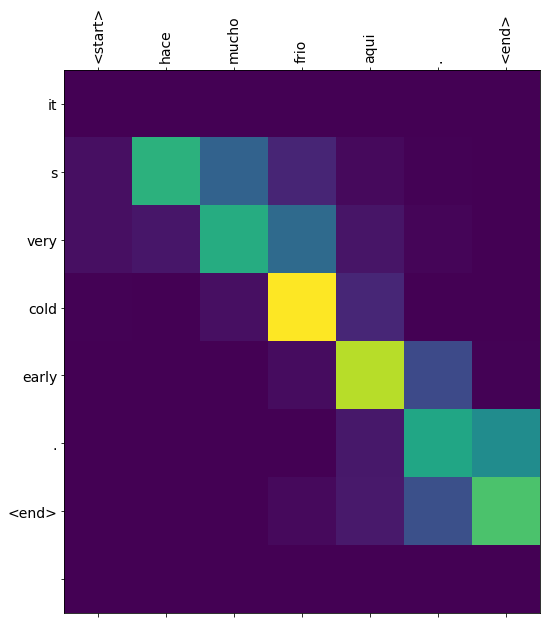

In [65]:
translate(u'hace mucho frio aqui.')